In [1]:
import sys
sys.path.append('../code')

from SamplingWalk import *
from portfolio_optimization import *
from xy_mixer import *
import dynamiqs as dq
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

# Problem: Portfolio optimization




## Problem generation

Portfolio optimization consists of selecting at most $k$ assets among $n$ to obtain the optimal portfolio. Each asset has an expected return and one aims at maximizing profit while minimizing financial risk. Each asset $i$ is associated to a binary variable $x_i\in\{0,1\}$ and $x_i=1$ if asset $i$ is in the portfolio. The limitation in the number of assets corresponds to bounding the Hamming weight of the solutions with a fixed value $k\in[0,n]$, i.e. choosing a constraint set as,
$$
\mathcal{F} = \left\{x \in \{0,1\}^n \hspace{2pt} \middle| \hspace{2pt} \sum_{i=1}^n x_i\leq k \right\}.
$$

The cost function reads:
$$C(x)=\lambda\sum_{i<j}\sigma_{ij}x_ix_j-\sum_{i}\mu_ix_i+\gamma\left(\sum_i x_i-k\right)^2,$$
with $\sigma\in \mathbb{R}^{n\times n}$ the covariance matrix between assets, $\mu\in \mathbb{R}^n$ is the expected return of the assets, $\lambda>0$ the risk appetite and $\gamma\geq 0$ the penalty coefficient. Note that since we will use $XY$-mixer to encode constraints in this notebook, we do not need to deal with contraints in the cost function, thus we set $\gamma=0$.

We generate an instance of Portfolio optimization on $n$ different assets where we must select $k$ of them.

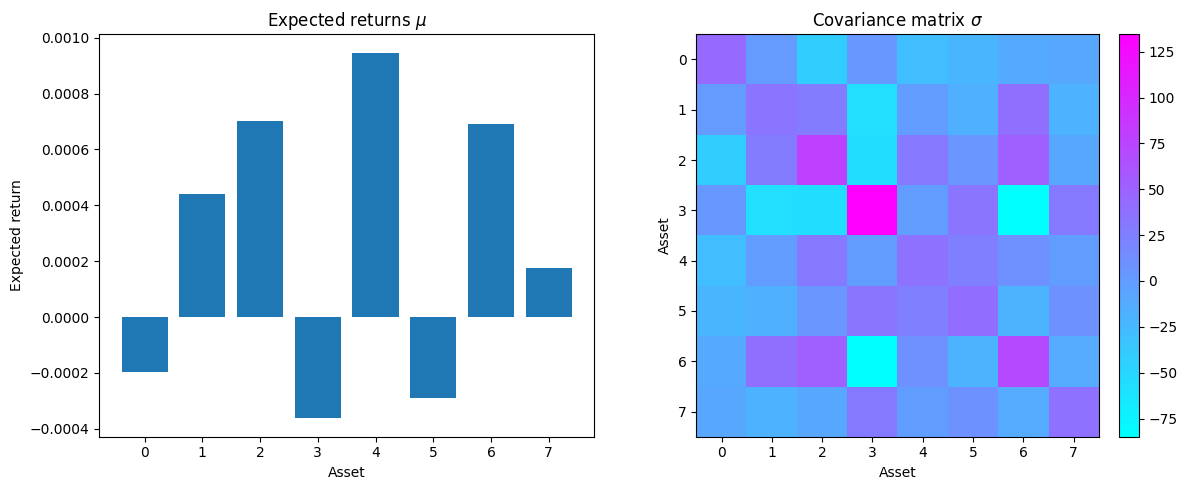

In [14]:
import datetime
from qiskit_finance.data_providers import RandomDataProvider

# Total number of assets (number of qubits)
n = 8

# Number of assets to select (Hamming weight of feasible solutions)
k = n//2 # 0 <= k <= n

# Risk appetite
lam = 1/2

# Penalty coefficient (set to 0 since we use XY-mixer to encode constraints)
gamma = 0

# Parameters
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2021, 1, 1)

# Create a random data provider
data = RandomDataProvider(
    tickers=[f"Asset {i}" for i in range(n)],
    start=start,
    end=end
)

# Generate the synthetic price data
data.run()

# Extract portfolio instance
mu = data.get_period_return_mean_vector()  # expected returns
sigma = data.get_covariance_matrix()       # covariance matrix

# Plot the expected returns and covariance matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: bar plot for μ ---
axes[0].bar(np.arange(len(mu)), mu)
axes[0].set_xlabel("Asset")
axes[0].set_ylabel("Expected return")
axes[0].set_title(r"Expected returns $\mu$")

# --- Right: heatmap for Σ ---
im = axes[1].imshow(sigma, cmap="cool", interpolation="nearest")
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
axes[1].set_title(r"Covariance matrix $\sigma$")
axes[1].set_xlabel("Asset")
axes[1].set_ylabel("Asset")

plt.tight_layout()
plt.show()

We first use a brute-force approach to compute the solutions of the problem to compare with the results obtained with SamBa GQW.

In [15]:
# Compute cost for all bitstrings
cost_values = []
for i in range(2**n):
    bitstr = int_to_bitstring(i,n)         # convert integer to binary vector
    cost_val = portfolio_cost(bitstr,lam, gamma, sigma, mu, k)
    cost_values.append(cost_val)

# -1 for non-feasible solutions
cost_quality_dict = cost_quality_by_hamming(cost_values,k)

We visualize the cost function on the solution space (graph with vertices of Hamming weight $k$) where the color of the vertices depends on their quality, which is 1 for optimal solutions, 0 for worst and -1 for non-feasible solutions (states with Hamming weight different than $k$). Since we use $XY$-mixer with (ring-connectivity), the solution space is composed of $n+1$ subgraphs that only connect states with same Hamming weight. Note that subgraph of Hamming weight $k$ contains ${n \choose k}$ vertices. Two vertices $x$ and $y$ are connected if they only differ by a swap of two adjacent different bits, i.e. if $y=\text{swap}_{i,(i+1)\mod n}(x)$ and $x_i\neq x_{(i+1)\mod n}$.

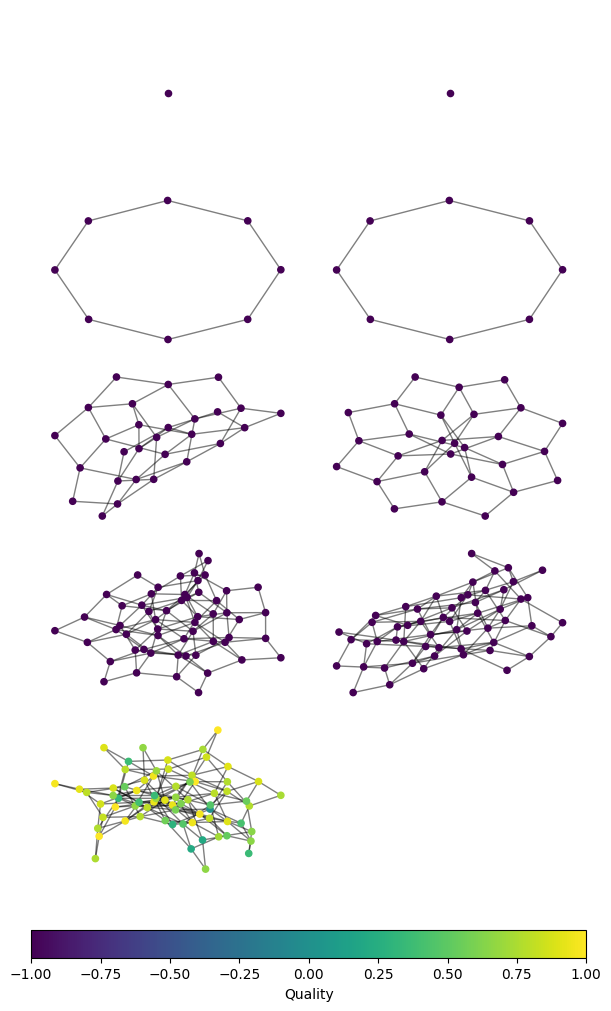

In [16]:
subgraphs = generate_all_hamming_subgraphs(n)
plot_all_subgraphs_grouped(subgraphs, n, cost_quality_dict, node_size=20, cmap='viridis')


## SamBa GQW: classical part

We create an instance of SamBa-GQW for Portfolio optimization with $XY$-mixer (with ring-connectivity), then we perform the sampling protocol and compute the mean of the sampled energy gaps.

In [17]:
# Creation of instance of SamBa GQW

use_qutip = False # QuTip or Dynamiqs

mixer = xy_ring_adjacency_sparse_final(n,use_qutip=use_qutip) # We use a sparse representation for Dynamiqs & dense for QuTip

# Uniform superposition over basis states of Hamming weight k
initial_state = np.array(uniform_superposition_hamming_range(n,k,k)).reshape((-1, 1))
if use_qutip:
    initial_state = Qobj(np.array(uniform_superposition_hamming_range(n,k,k)).reshape((-1, 1)))

samba_gqw = SamplingWalk(n,
                      cost=portfolio_cost, # Portfolio optimization cost function
                      mixer=mixer, # Mixer (here n-dimensional hypercube)
                      initial_state=initial_state, # For XY-mixers the initial state is not the uniform superposition over 2^n states
                      use_qutip=use_qutip, # QuTip or Dynamiqs
                      use_density_matrix=False, # State vector representation
                      convert_input_cost_fun=int_to_bitstring, # Function to convert integer to binary vectors
                      cost_kwargs={'lam':lam, 'gamma':gamma, 'sigma':sigma, 'mu':mu, 'k':k} # Additional inputs of the cost function
            )

# Sampling protocol
q = n**2 # Quadratic sampling
neighbors_fun = xy_ring_neighbors # XY-mixer (with ring-connectivity) neighboring function
samba_gqw.sampling_protocol(q=q, neighbors_fun=neighbors_fun)
samba_gqw.compute_mean_gaps()

We visualize the vertices (states) sampled on the solution graph.

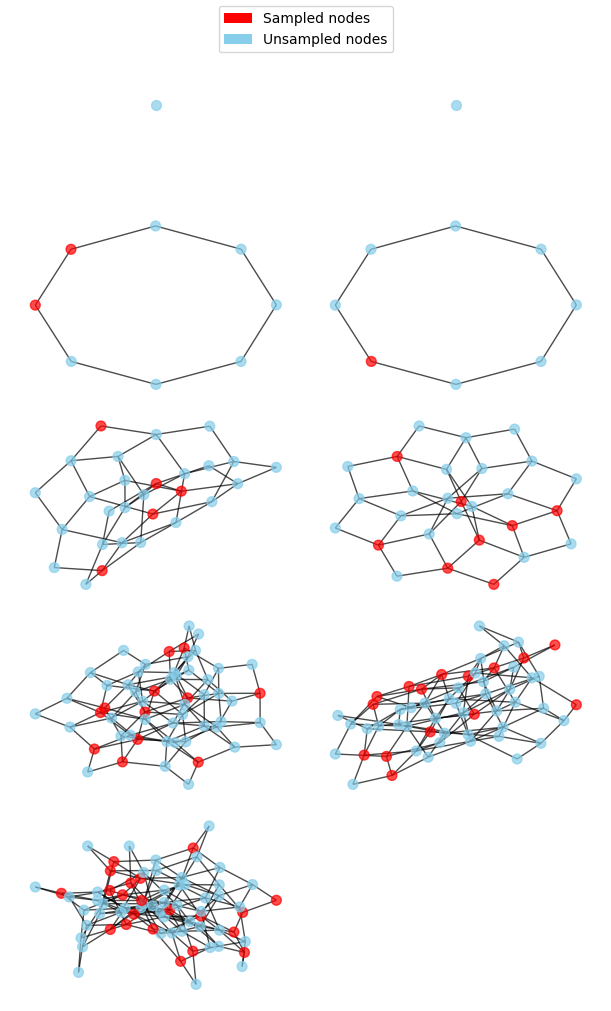

In [18]:
plot_all_subgraphs_sampled(subgraphs,n,samba_gqw.sampled_states)

### Interpolation of $\Gamma$

We construct the time-dependent hopping rate.

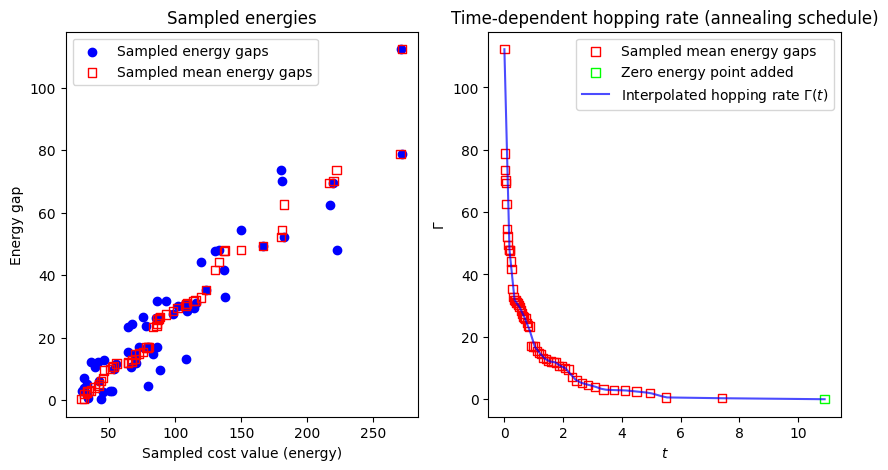

In [19]:
# Interpolation
samba_gqw.interpolate(dt=n**2)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- First plot ---
x_values = [val[0] for val in samba_gqw.sample.values()]
y_values = [val[1]/samba_gqw.local_mixer_gap for val in samba_gqw.sample.values()]

x_temp = samba_gqw.energies.copy()
new_temp = samba_gqw.np.concatenate([samba_gqw.np.array([samba_gqw.energies[0]]), x_temp])

# Scatter des cercles bleus (points "Sampled energy gaps")
axes[0].scatter(x_values, y_values, color='blue', label='Sampled energy gaps')

# Scatter des carrés rouges (hollow)
axes[0].scatter(samba_gqw.energies, samba_gqw.mean_gaps[::-1][1:], marker='s', facecolors='none', edgecolors='red', label="Sampled mean energy gaps")

axes[0].set_xlabel('Sampled cost value (energy)')
axes[0].set_ylabel('Energy gap')
axes[0].set_title('Sampled energies')
axes[0].legend()

# --- Second plot ---
# Scatter all points except last with hollow red squares
axes[1].scatter(samba_gqw.gap_dt[:-1], samba_gqw.mean_gaps[:-1], marker='s', facecolors='none', edgecolors='red', label='Sampled mean energy gaps')

# Scatter the last point in green (hollow)
axes[1].scatter(samba_gqw.gap_dt[-1:], samba_gqw.mean_gaps[-1:], marker='s', facecolors='none', edgecolors='lime', label='Zero energy point added')

# Plot interpolated hopping
axes[1].plot(samba_gqw.t_list, samba_gqw.hopping, color='blue', linestyle='-', linewidth=1.5, alpha=0.7, label="Interpolated hopping rate $\Gamma(t)$")

axes[1].set_xlabel('$t$')
axes[1].set_ylabel('$\Gamma$')
axes[1].set_title('Time-dependent hopping rate (annealing schedule)')
axes[1].legend()

plt.show()


## SamBa GQW: quantum part
We now solve the problem using SamBa GQW with the Hamiltonian evolution (continuous version).

### Hamiltonian evolution

In [20]:
# We perform the Hamiltonian evolution
results = samba_gqw.evolve()

# We extract the results
if samba_gqw.use_qutip:
    results_array = np.array([state.full() for state in results.states]) # array of quantum states
    times = results.times # values of evaluated time
else:
    results_array = np.array([state.to_numpy() for state in results.states]) # array of quantum states
    times = results.tsave # values of evaluated time

|██████████| 100.0% ◆ elapsed 499.43ms ◆ remaining 0.00ms  


#### Results visualization

We compute several metrics for analysis purposes.

In [21]:
from performance_metrics import *

rank_dict = rank_solutions_by_quality(cost_quality_dict)
prob_over_time = [(np.abs(state)**2).reshape(-1) for state in results_array]
distribution_quality_over_time = [distribution_quality(pr,list(cost_quality_dict.values())) for pr in prob_over_time]
probabilities_per_rank_over_time = [[np.sum(pr[rank_dict[r]]) for pr in prob_over_time] for r in list(rank_dict.keys())]
patricipation_ratio_over_time = 1 / (2**n * np.sum(np.vstack(prob_over_time)**2, axis=1))

We first plot the several metrics over time.

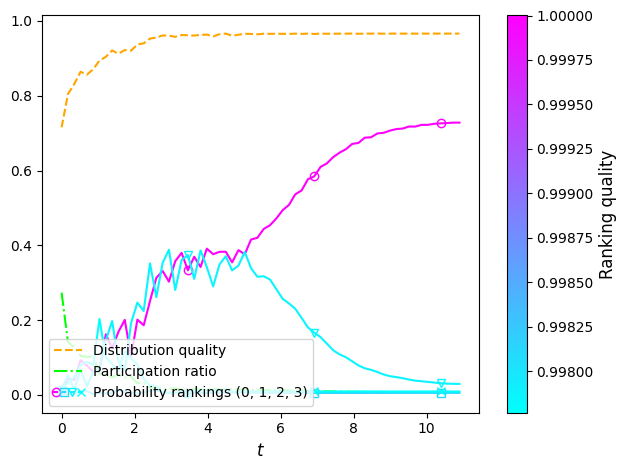

In [22]:
# We select the rankings for which we want to display the measurement probabilities over time
rank_to_display = [0,1,2,3]

# We plot several metrics over time
plot_performance(
    distribution_quality_over_time,
    patricipation_ratio_over_time,
    probabilities_per_rank_over_time,
    times,
    [cost_quality_dict[rank_dict[i][0]] for i in list(rank_dict.keys())],
    rank_list=rank_to_display,
    rank_dict=rank_dict,
    pourcentage=0,
    marker_list=None,
    markevery=20,
    markersize=6,
    show_colorbar=True,
    show_legend=True
)

We then plot the initial and final ranking distributions.

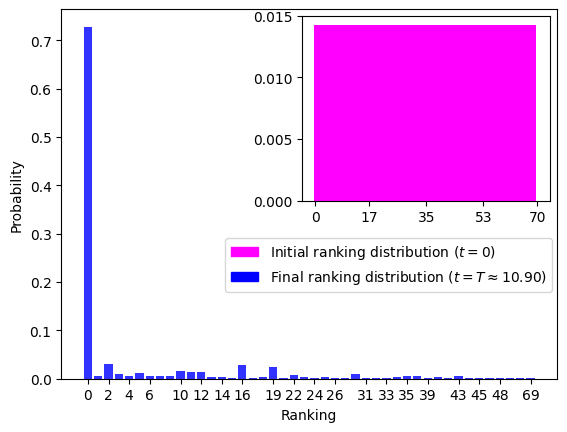

In [23]:
prob_per_rank_init = np.array([probabilities_per_rank_over_time[r][0] for r in list(rank_dict.keys())])
prob_per_rank_final = np.array([probabilities_per_rank_over_time[r][-1] for r in list(rank_dict.keys())])

plot_ranking_distribution(prob_per_rank_final=prob_per_rank_final,
                        prob_per_rank_init=prob_per_rank_init,
                        threshold=1e-3,
                        num_ticks=20,
                        inset_plot_size=50,
                        inset_plot_label='Initial ranking distribution ($t=0$)',
                        main_plot_label=f'Final ranking distribution ($t=T\\approx {times[-1]:.2f}$)',
                        save=False,
                        figname='ranking_distribution.png')

We simulate measurements in the computational basis and we select the best found approximation to be the **measured** state with lowest cost.

The best found assignment is x=201 (11001001) of ranking r=0


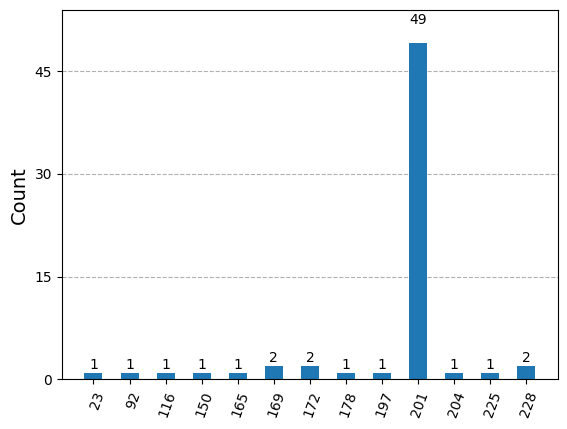

In [24]:
from collections import Counter
from qiskit.visualization import plot_histogram

def sample_measurements(probabilities, k, seed=None):
    """
    Simulate k measurements from a probability distribution.
    
    Args:
        probabilities (array-like): probability vector that sums to 1
        k (int): number of measurements
        seed (int, optional): random seed for reproducibility
    
    Returns:
        dict: {index: count of times measured}
    """
    rng = np.random.default_rng(seed)
    n = len(probabilities)
    outcomes = rng.choice(np.arange(n), size=k, p=probabilities)
    counts = dict(Counter(outcomes))
    return counts

# Number of measurements
n_shots = n**2

# Simulate the measurements
res = sample_measurements(prob_over_time[-1], n_shots, seed=42)

# Print the best found assignment
best_found_assigment = min(res.keys(), key=lambda b: portfolio_cost(int_to_bitstring(b,n),lam, gamma, sigma, mu, k))
print(f"The best found assignment is x={best_found_assigment} "
      f"({format(best_found_assigment, f'0{n}b')}) "
      f"of ranking r={next((key for key, values in rank_dict.items() if best_found_assigment in values))}")

# Plot the results of the measurements
plot_histogram(res)

We plot the selected assets and the expected return as a function of risk.

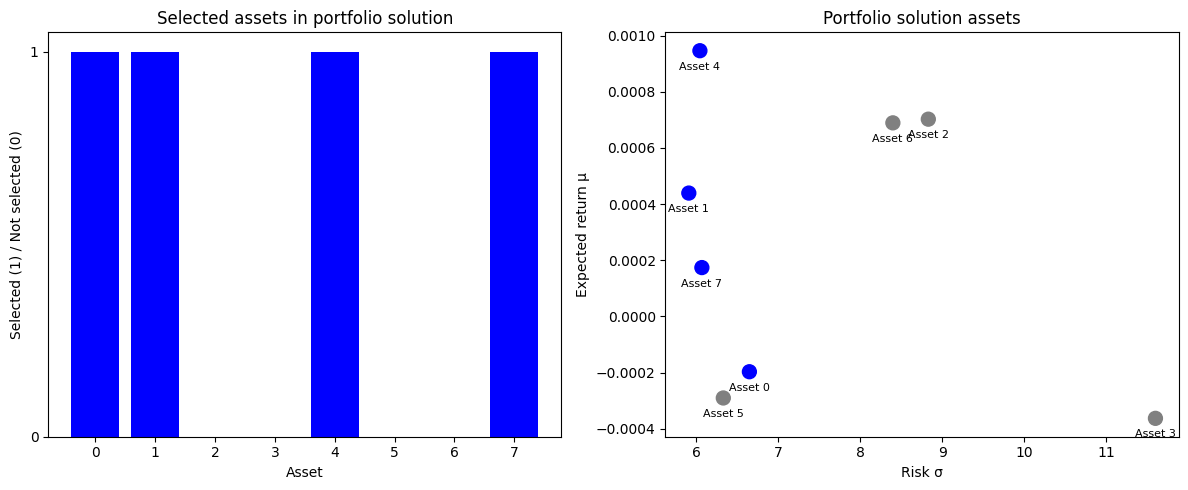

In [25]:
solution = int_to_bitstring(best_found_assigment, n)

# Create a single figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart of selected assets
axes[0].bar(np.arange(n), solution, color=['blue' if s else 'gray' for s in solution])
axes[0].set_xlabel("Asset")
axes[0].set_ylabel("Selected (1) / Not selected (0)")
axes[0].set_xticks(np.arange(n))
axes[0].set_yticks([0, 1])
axes[0].set_title("Selected assets in portfolio solution")

# Risk-return scatter plot
x = np.sqrt(np.diag(sigma))  # risk
y = mu  # expected return
colors = ['blue' if s else 'gray' for s in solution]

axes[1].scatter(x, y, s=100, c=colors)

# Add labels just below each point
y_offset = (max(y) - min(y)) * 0.03
for i, label in enumerate([f"Asset {i}" for i in range(n)]):
    axes[1].text(x[i], y[i] - y_offset, label, fontsize=8, ha='center', va='top')

axes[1].set_xlabel("Risk σ")
axes[1].set_ylabel("Expected return μ")
axes[1].set_title("Portfolio solution assets")

plt.tight_layout()
plt.show()
